In [9]:
import re
import os 
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.style.use("paper")
# colors = ["#ef476f","#118ab2","#ffd166","#06d6a0","#073b4c"]
colors = ["#1982c4","#ff595e","#ffca3a","#8ac926","#6a4c93"]

In [2]:
re_file = re.compile("(?P<label>.*?)_(?P<type>.*?)_(?P<scan_num>\d)_.*?\.csv")
# datapath = r"C:\Users\weiwe\Documents\Texas Instruments\NIRscanNano\wraps"
# re_file = re.compile("^.*?_(.*?)_(\d)_.*?\.csv")

all_data = {}
all_labels = {}

In [5]:
# datapath = r"D:\projects\NIRS_all\NIRS-Generic\src\django_server\nirs_server\apps\glutentest\nirs_models\data\reference\processed_nolabel"
datapath = r"../nirs_models/data/reference/processed_nolabel"
all_filenames = os.listdir(datapath)

for filename in all_filenames:
    re_result = re_file.match(filename)
    if re_result:
        scan_num = str(int(re_result.group("scan_num")) + 3)
        data = np.loadtxt(os.path.join(datapath, filename), skiprows=0, delimiter=",")
        data[:, 1] = np.log10(data[:, 2] / data[:, 1])
        label = re_result.group("label")
        if scan_num in all_data:
            all_data[scan_num].append(data)
            all_labels[scan_num].append(label)
        else:
            all_data[scan_num] = [data]
            all_labels[scan_num] = [label]

print(len(all_data))

3


In [6]:
# datapath = r"D:\projects\NIRS_all\NIRS-Generic\src\django_server\nirs_server\apps\glutentest\nirs_models\data\reference\processed"
datapath = r"../nirs_models/data/reference/processed"
all_filenames = os.listdir(datapath)

class_counter = {}
for filename in all_filenames:
    re_result = re_file.match(filename)
    if re_result:
        # Type counter. 
        scan_num = re_result.group("scan_num")
        wrap_type = re_result.group("type") + scan_num
        if wrap_type in class_counter:
            class_counter[wrap_type] += 1
        else:
            class_counter[wrap_type] = 1
        
#         if class_counter[wrap_type] > 3:
#             continue
        
        data = np.loadtxt(os.path.join(datapath, filename), skiprows=0, delimiter=",")
        data[:, 1] = np.log10(data[:, 2] / data[:, 1])
        label = re_result.group(1)
        if scan_num in all_data:
            all_data[scan_num].append(data)
            all_labels[scan_num].append(label)
        else:
            all_data[scan_num] = [data]
            all_labels[scan_num] = [label]

print(len(all_data))

6


In [7]:
# datapath = r"D:\projects\NIRS_all\NIRS-Generic\src\django_server\nirs_server\apps\glutentest\nirs_models\data\reference\processed_russian"
datapath = r"../nirs_models/data/reference/processed_russian"
all_filenames = os.listdir(datapath)

for filename in all_filenames:
    re_result = re_file.match(filename)
    if re_result:
        scan_num = str(int(re_result.group("scan_num")) + 6)
        data = np.loadtxt(os.path.join(datapath, filename), skiprows=0, delimiter=",")
        data[:, 1] = np.log10(data[:, 2] / data[:, 1])
        label = re_result.group("label")
        if scan_num in all_data:
            all_data[scan_num].append(data)
            all_labels[scan_num].append(label)
        else:
            all_data[scan_num] = [data]
            all_labels[scan_num] = [label]

print(len(all_data))

9


['Gluten-free', 'Not-gluten-free']
Data size: (675, 228)
Label size: (675,)


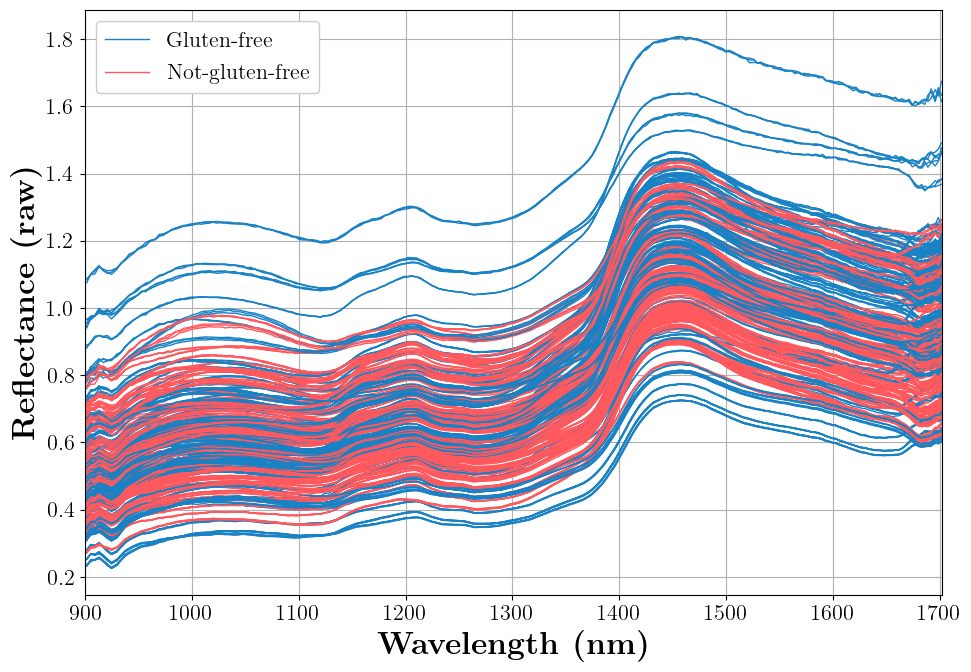

In [21]:
# Show all raw data.
all_data_raw = np.concatenate([np.array(sub_dataset)[:, :, 1] for sub_dataset in all_data.values()])
all_labels_raw = np.concatenate([labels for labels in all_labels.values()])
all_classes = list(np.unique(all_labels_raw))
print(all_classes)

wavelengths = all_data["1"][0][:, 0]

print("Data size: {}".format(all_data_raw.shape))
print("Label size: {}".format(all_labels_raw.shape))

fig, ax = plt.subplots(dpi=100)
ax.set_xlim([np.floor(wavelengths.min()-1), np.ceil(wavelengths.max())])
ax.set_xlabel(r"\textbf{Wavelength (nm)}")
ax.set_ylabel(r"\textbf{Reflectance (raw)}")

# colors = ["#1f77b4", "#ff7f0e"]
legends = []
for data, label in zip(all_data_raw, all_labels_raw):
    
    # Add legend. 
    if label in legends:
        legend = None
    else:
        legend = label
        legends.append(legend)
        
    color = colors[all_classes.index(label)]
        
    ax.plot(wavelengths, data, label=legend, color=color, alpha=1.0, linewidth=1.0)

# Order legend.
legend_handles, legend_labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: t[0]))
ax.legend(legend_handles, legend_labels)


fig.tight_layout()
fig.savefig("./figure/gluten_raw_data.pdf", dpi=300)
fig.savefig("./figure/gluten_raw_spectra.pdf", dpi=300)


In [11]:
from scipy.signal import savgol_filter
from scipy.signal import detrend

wavelength_idx_start = 25
wavelength_idx_end = 200

sliced_wavelengths = all_data["1"][0][:, 0][wavelength_idx_start:wavelength_idx_end]
sliced_wavelengths_left = all_data["1"][0][:, 0][:wavelength_idx_start]
sliced_wavelengths_right = all_data["1"][0][:, 0][wavelength_idx_end:]

print("{} ~ {}".format(np.min(sliced_wavelengths), np.max(sliced_wavelengths)))

# Clean data.
all_data_processed = {}
all_data_processed_truncated_left = {}
all_data_processed_truncated_right = {}
for key, item in all_data.items():
#     all_data_processed[key] = savgol_filter(
#         np.array(item)[:, :, 1], window_length=21, polyorder=3)

    processed_spectra = np.gradient(savgol_filter(np.array(item)[:, :, 1], window_length=21, polyorder=3), axis=1)
    all_data_processed[key] = processed_spectra[:, wavelength_idx_start:wavelength_idx_end]
    all_data_processed_truncated_left[key] = processed_spectra[:, :wavelength_idx_start]
    all_data_processed_truncated_right[key] = processed_spectra[:, wavelength_idx_end:]
#     all_data_processed[key] = detrend(
#         savgol_filter(np.array(item)[:, :, 1], window_length=5, polyorder=3), axis=1)
    print("{}: {}".format(key, all_data_processed[key].shape))
    
# Split data.
# from sklearn.model_selection import train_test_split
# all_data_train, all_test_data, all_labels_train, all_labels_test = train_test_split(
#     all_data_processed, all_labels, test_size=0.9)

train_keys = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
test_keys = ["7", "8", "9"]

# Stucturing data.
all_data_train = np.concatenate([all_data_processed[key] for key in train_keys])
all_labels_train = np.concatenate([all_labels[key] for key in train_keys])
all_data_test = np.concatenate([all_data_processed[key] for key in test_keys])
all_labels_test = np.concatenate([all_labels[key] for key in test_keys])
all_data_train_truncated_left = np.concatenate([all_data_processed_truncated_left[key] for key in train_keys])
all_data_train_truncated_right = np.concatenate([all_data_processed_truncated_right[key] for key in train_keys])

# all_data_train, all_data_test = all_data_test, all_data_train
# all_labels_train, all_labels_test = all_labels_test, all_labels_train

# all_data_train = np.array(list(all_data_train) + list(all_data_test))
# all_labels_train = np.array(list(all_labels_train) + list(all_labels_test))

print(all_data_train.shape)
print(all_data_test.shape)

1000.176314 ~ 1615.290929
5: (57, 175)
4: (57, 175)
6: (57, 175)
2: (108, 175)
3: (120, 175)
1: (114, 175)
9: (54, 175)
7: (54, 175)
8: (54, 175)
(675, 175)
(162, 175)


/anaconda3/envs/data/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


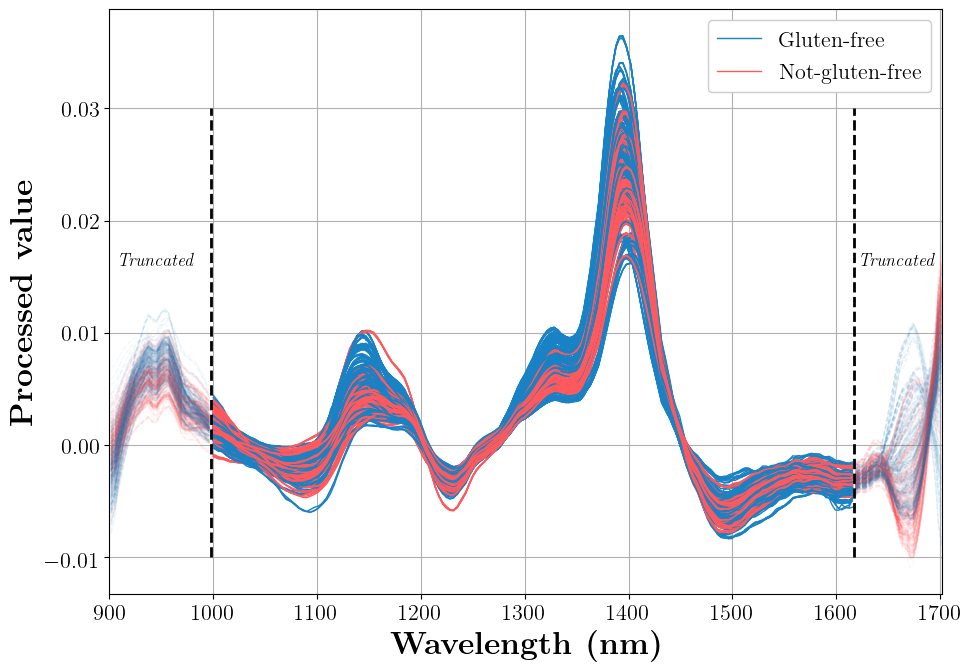

In [22]:
# Show all processed data.
fig, ax = plt.subplots(dpi=100)
ax.set_xlim([np.floor(wavelengths.min()-1), np.ceil(wavelengths.max())])
ax.set_xlabel(r"\textbf{Wavelength (nm)}")
ax.set_ylabel(r"\textbf{Processed value}")

# colors = ["#1f77b4", "#ff7f0e"]
legends = []
for data_left, data, data_right, label in zip(all_data_train_truncated_left, all_data_train, all_data_train_truncated_right, all_labels_train):
    
    # Add legend. 
    if label in legends:
        legend = None
    else:
        legend = label
        legends.append(legend)
        
    color = colors[all_classes.index(label)]
    
    ax.plot(sliced_wavelengths_left, data_left, color=color, alpha=0.05, linewidth=1.0, linestyle="--")
    ax.plot(sliced_wavelengths, data, label=legend, color=color, alpha=1.0, linewidth=1.0)
    ax.plot(sliced_wavelengths_right, data_right, color=color, alpha=0.05, linewidth=1.0, linestyle="--")

# Annotate the truncated parts.
wavelength_boarder_left = (sliced_wavelengths_left[-1] + sliced_wavelengths[0]) / 2
wavelength_boarder_right = (sliced_wavelengths_right[0] + sliced_wavelengths[-1]) / 2
ax.plot([wavelength_boarder_left, wavelength_boarder_left], [-0.01, 0.03], color="k", linestyle="--")
ax.plot([wavelength_boarder_right, wavelength_boarder_right], [-0.01, 0.03], color="k", linestyle="--")
ax.annotate(r"\textit{Truncated}", xy=(910, 0.016), xytext=(910, 0.016), size=13)
ax.annotate(r"\textit{Truncated}", xy=(1624, 0.016), xytext=(1624, 0.016), size=13)

# Order legend.
legend_handles, legend_labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
legend_labels, legend_handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: t[0]))
ax.legend(legend_handles, legend_labels)

fig.tight_layout()
fig.savefig("./figure/gluten_processed_data.pdf", dpi=300)
fig.savefig("./figure/gluten_processed_spectra.pdf", dpi=300)

In [23]:
# Read test data from from anther notebook.
%store -r all_test_data
%store -r all_test_labels
%store -r all_test_data_flattened
%store -r all_test_labels_flattened

no stored variable all_test_data
no stored variable all_test_labels
no stored variable all_test_data_flattened
no stored variable all_test_labels_flattened


In [13]:
# Grid search.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Pre-define train-test split.
all_data_combined = list(all_data_train) + list(all_test_data_flattened)
all_labels_combined = list(all_labels_train) + list(all_test_labels_flattened)
predefined_split = PredefinedSplit([-1] * len(all_data_train) + [0] * len(all_test_data_flattened))

models = {
    "RFC": [RandomForestClassifier(), 
            {"n_estimators":np.arange(1, 101, 1)}],
#             {"max_features":np.arange(1, 101, 1),"n_estimators":[20], "min_samples_leaf": [10,50,100,200,500]}],
#             {"max_features":[1] + list(range(10, 101, 10)),"n_estimators":[20], "min_samples_leaf": [1] + list(range(10, 101, 10))}],
    "SVC": [SVC(),
            {"C":np.arange(1, 101, 1), "probability":[True], "class_weight": ["balanced"]}],
}

all_grids = {}
for key, item in models.items():
    print(key)
    model, parameters = item
    grid = GridSearchCV(model, parameters, cv=predefined_split, return_train_score=True)
    grid.fit(all_data_combined, all_labels_combined)
    
    # Save grid.
    all_grids[key] = grid

NameError: name 'all_test_data_flattened' is not defined

In [12]:
# Plot.
xlabel_names = {
    "RFC": "Number of estimators (trees) in the forest",
    "SVC": "Regularization parameter C"
}

for key, grid in all_grids.items():
#     fig, axes = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
#     axes[0].set_xlabel(list(models[key][1].keys())[0].replace("_", " "))
#     axes[0].set_ylabel("Train accuracy")
#     axes[1].set_xlabel(list(models[key][1].keys())[0].replace("_", " "))
#     axes[1].set_ylabel("Validation accuracy")
#     axes[0].plot(grid.cv_results_["mean_train_score"][:100])
#     axes[1].plot(grid.cv_results_["mean_test_score"][:100])
    
#     fig.tight_layout()
    fig, ax = plt.subplots()
    ax.set_ylim([0.48, 1.09])
    ax.set_xlabel("\\textbf{{{}}}".format(xlabel_names[key]))
    ax.set_ylabel(r"\textbf{Accuracy}")
    ax.plot(range(1,101), grid.cv_results_["mean_train_score"][:100], "-", label="Training score")
    ax.plot(range(1,101), grid.cv_results_["mean_test_score"][:100], "-", label="Test score")
    ax.legend()
    fig.tight_layout()
    
    fig.savefig("figure/gluten_model_grid_search_{}.pdf".format(key), dpi=300)

NameError: name 'all_grids' is not defined

In [12]:
# Save the best models respectively.
import pickle

for key, item in all_grids.items():
    model = item.best_estimator_
    print(model)
#     print(item.cv_results_["mean_train_score"][item.best_index_])
#     print(item.cv_results_["mean_test_score"][item.best_index_])
    print(item.cv_results_["mean_train_score"][15])
    print(item.cv_results_["mean_test_score"][15])
    
    with open("./output/" + key, "wb") as f:
        pickle.dump({"model": model, "classes": list(model.classes_)}, f)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=29,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
1.0
0.7764227642276422
SVC(C=64, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
0.8933333333333333
0.8536585365853658


In [13]:
# Train using best parameters and save models.

svc_model = SVC(C=1., probability=True)
rf_model = RandomForestClassifier(n_estimators=10)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100), activation="identity", solver="lbfgs")

svc_model.fit(all_data_train, all_labels_train)
rf_model.fit(all_data_train, all_labels_train)
mlp_model.fit(all_data_train, all_labels_train)

import pickle
with open("./output/SVC", "wb") as f:
    pickle.dump({"model": svc_model, "classes": list(svc_model.classes_)}, f)
    
with open("./output/RFC", "wb") as f:
    pickle.dump({"model": rf_model, "classes": list(rf_model.classes_)}, f)
    
with open("./output/MLP", "wb") as f:
    pickle.dump({"model": mlp_model, "classes": list(mlp_model.classes_)}, f)

pass

0.7614814814814815
0.7222222222222222


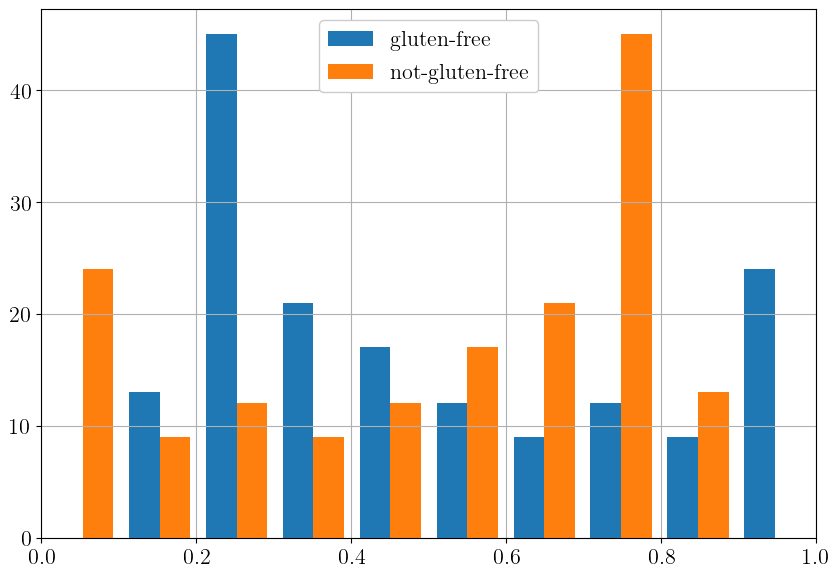

In [14]:
print(svc_model.score(all_data_train, all_labels_train))
print(svc_model.score(all_data_test, all_labels_test))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.hist(svc_model.predict_proba(all_data_test), label=["gluten-free", "not-gluten-free"])
ax.legend()

1.0
1.0


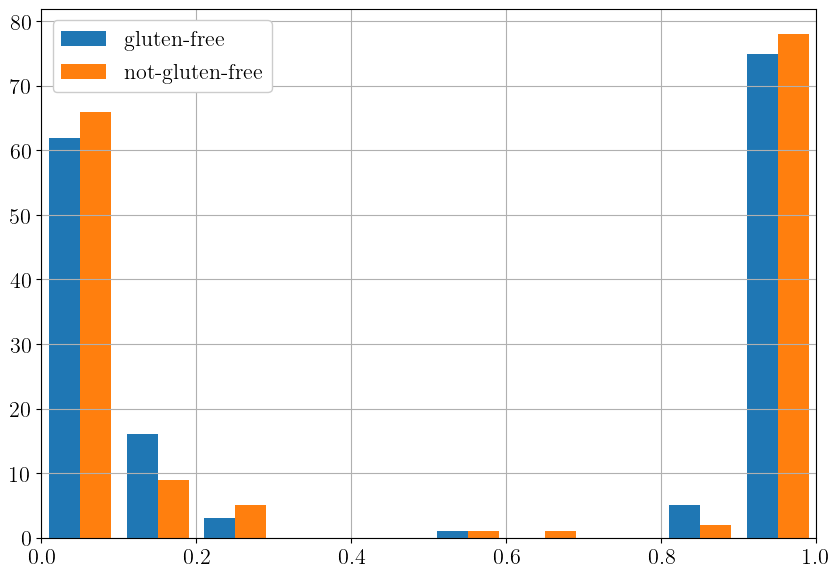

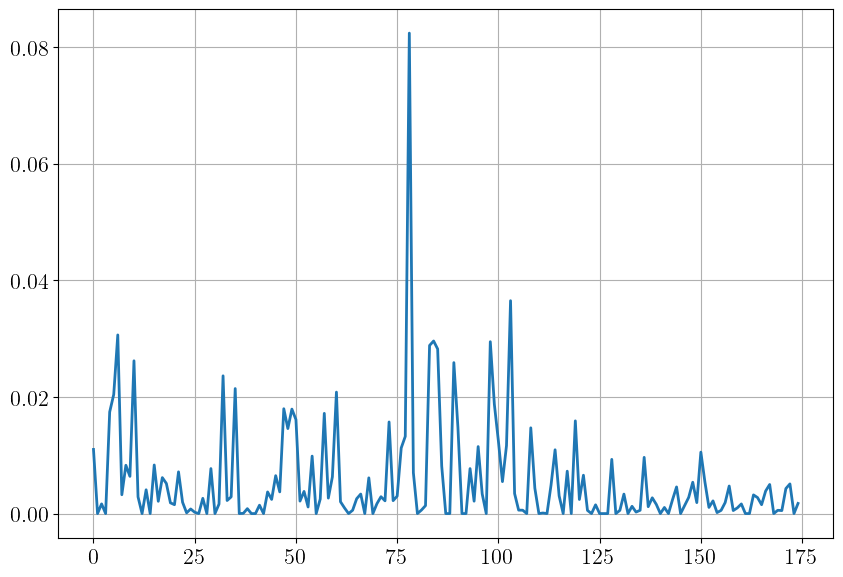

In [15]:
print(rf_model.score(all_data_train, all_labels_train))
print(rf_model.score(all_data_test, all_labels_test))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.hist(rf_model.predict_proba(all_data_test), label=["gluten-free", "not-gluten-free"])
ax.legend()

fig, ax = plt.subplots()
ax.plot(rf_model.feature_importances_)

0.6711111111111111
0.6790123456790124


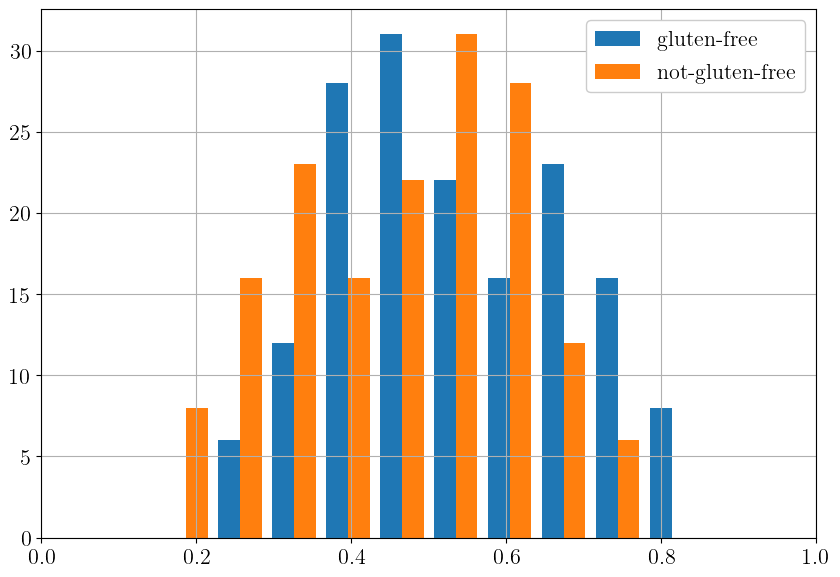

In [16]:
print(mlp_model.score(all_data_train, all_labels_train))
print(mlp_model.score(all_data_test, all_labels_test))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.hist(mlp_model.predict_proba(all_data_test), label=["gluten-free", "not-gluten-free"])
ax.legend()

In [17]:
# Export data. 